# ** Vehicle Detection Project**

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# import all necessary libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
#from sklearn import svm
from scipy.ndimage.measurements import label

# Read the vehicle and non-vehicle images

In [2]:
def read_img (file_path):
    file_names = glob.glob(file_path)
    imgs = []
    prt_cnt = 0
    for file in file_names:
        img = cv2.imread(file)
        # scale image size to be 64 by 64
        img_small = cv2.resize(img, (64, 64), interpolation=cv2.INTER_NEAREST)
        imgs.append(img_small)
        if prt_cnt % 1000 == 0:
            print("finish read image number", prt_cnt)
        
        prt_cnt += 1
    print("complete read " + file_path)
    return imgs
    
# Make a list of ve images
vehicle_imgs     = read_img('vehicles/*/*.png')
non_vehicle_imgs = read_img('non-vehicles/*/*.png')

finish read image number 0
finish read image number 1000
finish read image number 2000
finish read image number 3000
finish read image number 4000
finish read image number 5000
finish read image number 6000
finish read image number 7000
finish read image number 8000
complete read vehicles/*/*.png
finish read image number 0
finish read image number 1000
finish read image number 2000
finish read image number 3000
finish read image number 4000
finish read image number 5000
finish read image number 6000
finish read image number 7000
finish read image number 8000
complete read non-vehicles/*/*.png


# Feature extraction for images

In [4]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features (image, spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, fig_name=None):
    
    img_YUV = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    color_feature = color_hist(img_YUV)
    
    #spatial_features = bin_spatial(img_YUV)
    spatial_features = cv2.resize(img_YUV[:,:,0], spatial_size).ravel()
    
    if fig_name is None:
        hog_feat1 = hog(img_YUV[:, :, 0], orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=False, feature_vector=False)
        hog_feat2 = hog(img_YUV[:, :, 1], orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=False, feature_vector=False)    
        hog_feat3 = hog(img_YUV[:, :, 2], orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=False, feature_vector=False)     
    else: 
        hog_feat1,hog_image1 = hog(img_YUV[:, :, 0], orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=True, feature_vector=False)
        hog_feat2,hog_image2 = hog(img_YUV[:, :, 1], orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=True, feature_vector=False)    
        hog_feat3,hog_image3 = hog(img_YUV[:, :, 2], orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=True, feature_vector=False)
        
    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))    
 
    file_features = np.concatenate((color_feature, spatial_features, hog_features.ravel()))
   
    # show all feastures if needed
    if fig_name is not None:
        # plot and save HOG features
        f, ax = plt.subplots(2, 2, figsize=(20,15))
        ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[0,0].set_title('Original Image', fontsize=30)
    
        ax[0,1].imshow(hog_image1, cmap='gray')
        ax[0,1].set_title('Y Channel HOG Visualization', fontsize=30)
    
        ax[1,0].imshow(hog_image2, cmap='gray')
        ax[1,0].set_title('U Channel HOG Visualization', fontsize=30)
        
        ax[1,1].imshow(hog_image3, cmap='gray')
        ax[1,1].set_title('V Channel HOG Visualization', fontsize=30)
       
        plt.savefig(fig_name,pad_inches=3)
        plt.show()
        
    return file_features
                                   
def extract_features_training(imgs):
    """ this function is to extract the features from the images """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = extract_features(image)                                   
        features.append(file_features)
    # Return list of feature vectors
    return features

In [5]:
# extract vehicle and non-vehicle features
vehicle_features     = extract_features_training(vehicle_imgs)
print('Complete vehicle feature extraction')
non_vehicle_features = extract_features_training(non_vehicle_imgs)
print('Complete non-vehicle feature extraction')


C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Complete vehicle feature extraction
Complete non-vehicle feature extraction


# Show the feature properties

C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


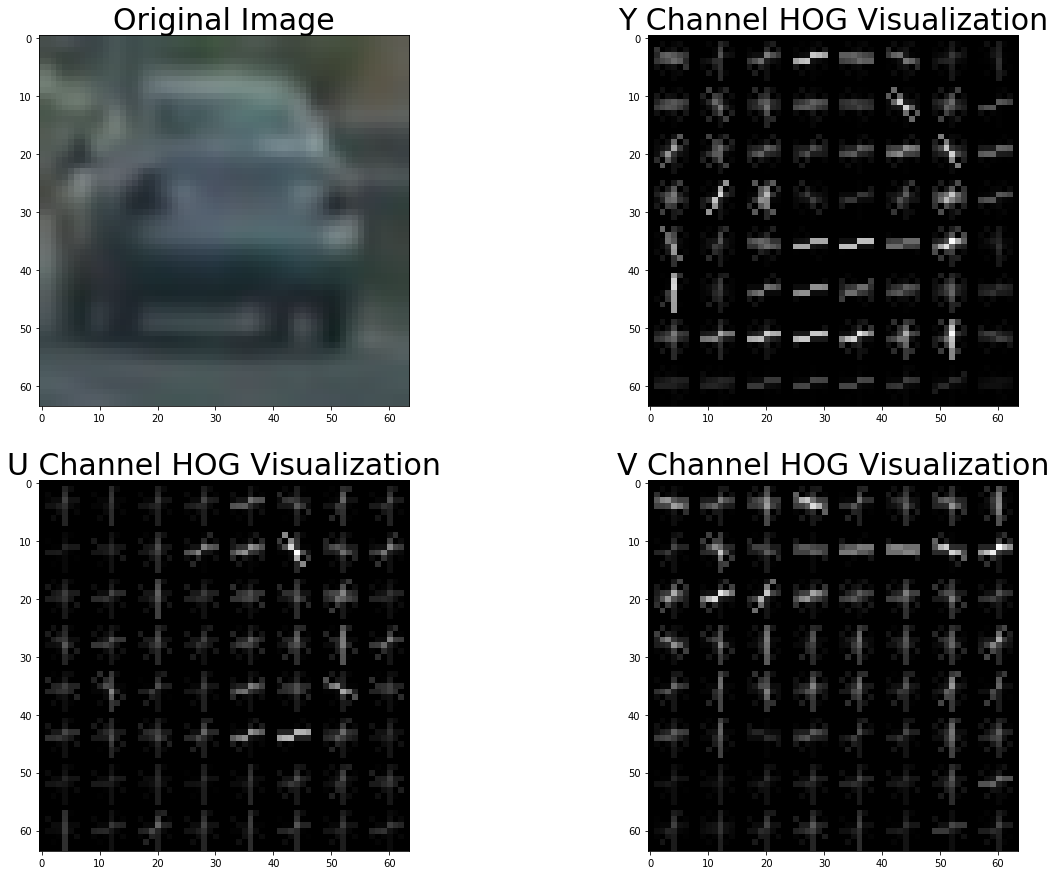

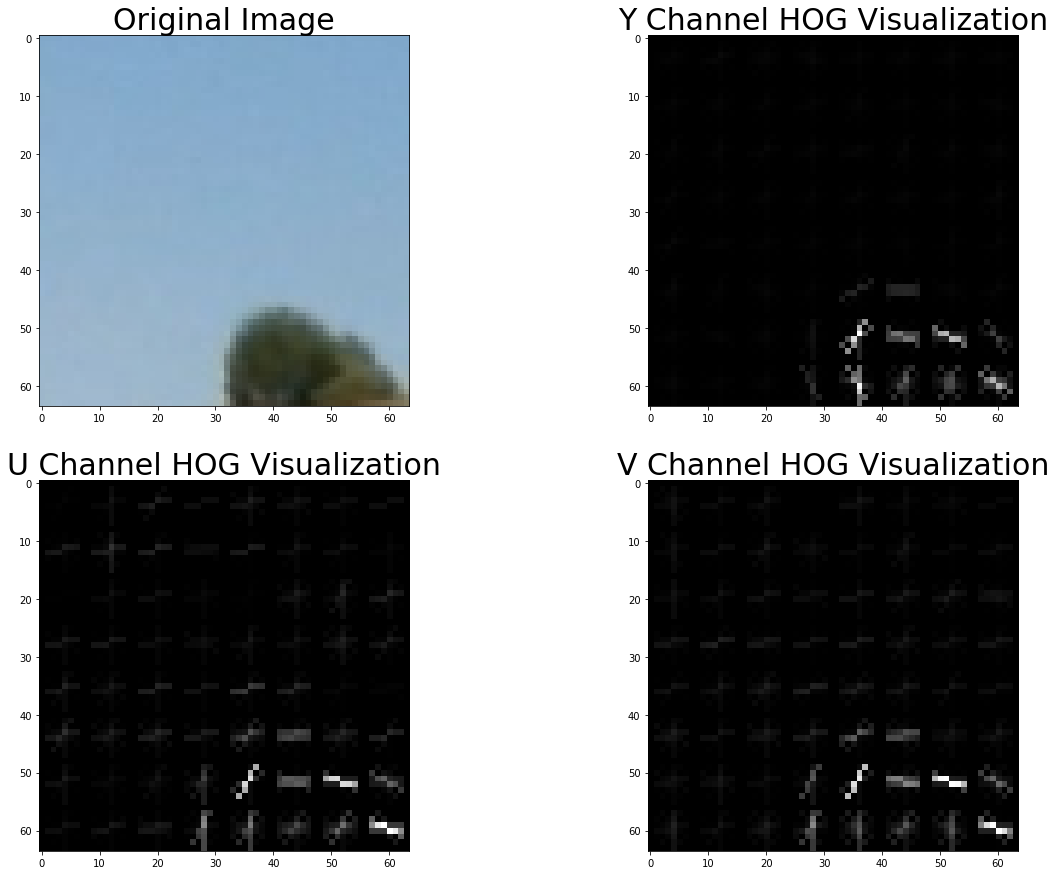

In [6]:
#extract_features (image)
dummy = extract_features (vehicle_imgs[23], fig_name= 'vehicle_feature.png')
dummy = extract_features (non_vehicle_imgs[233],  fig_name= 'non_vehicle_feature.png')

# Preprocess feature data

In [7]:
def preprocess_feature (vehicle_features, non_vehicle_features):
    """ this function is to preprocess features for the classifier """
    # Create an array stack of feature vectors
    X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # generate the label data
    vehicle_shape     = np.shape(vehicle_features)
    non_vehicle_shape = np.shape(non_vehicle_features)
    y  =  np.vstack((np.ones((vehicle_shape[0], 1)), np.zeros((non_vehicle_shape[0], 1))))
    
    # split the data into training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    return X_train, X_test, y_train, y_test, X_scaler

X_train, X_test, y_train, y_test, X_scaler = preprocess_feature (vehicle_features, non_vehicle_features)

# Training classifier

In [8]:
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc =  LinearSVC(C=0.01)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Training Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.decision_function(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Feature vector length: 6412


C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


16.37 Seconds to train SVC...
Training Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9916
My SVC predicts:  [ 1.77429614  2.06320315 -0.86130914  1.96521345  1.88542467 -1.38936341
 -3.83101631 -2.5424948  -1.97281872 -3.13643655]
For these 10 labels:  [[ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
0.003 Seconds to predict 10 labels with SVC


# Slide window

In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """ Define a function that takes an image, start and stop positions in both x and y, 
        window size (x and y dimensions), and overlap fraction (for both x and y)"""
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.ceil(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.ceil(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append([[startx, starty], [endx, endy]])
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, box, decision_value):
    # Assuming each "box" takes the form ((x1, y1), (x2, y2))
    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += decision_value
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # find the maximum value of the heatmap
    max_value = np.max(heatmap)
    # Zero out pixels below the threshold
    valid_indx = (heatmap <= threshold) | (heatmap < 0.5 * max_value)   
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

In [10]:
def extract_features_image (image, hog_feat1, hog_feat2, hog_feat3, window, spatial_size=(32, 32), hist_bins=32):
    
    # obtain the image patch from the whole image
    img_patch = image[window[0][1]:window[1][1], window[0][0]:window[1][0]] 
        
    # extract S channel feature from HSV color space
    #img_HSV = cv2.cvtColor(img_patch, cv2.COLOR_BGR2HSV)
    #S_hist = np.histogram(img_HSV[:,:,1], bins=hist_bins, range=(0, 256))
    
    # extract the spatial feature from a gray scale picture
    #rgb_img = cv2.resize(image, spatial_size)
    #gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    #spatial_features = gray_img.ravel()
    
    img_YUV = cv2.cvtColor(img_patch, cv2.COLOR_BGR2YUV)
    color_feature = color_hist(img_YUV)
    
    #spatial_features = bin_spatial(img_YUV)
    spatial_features = cv2.resize(img_YUV[:,:,0], (32,32)).ravel()
    
    # extract HOG feature 
    local_hog1 = hog_feat1[window[0][1]/8:window[1][1]/8 - 1, window[0][0]/8:window[1][0]/8 - 1]
    local_hog2 = hog_feat2[window[0][1]/8:window[1][1]/8 - 1, window[0][0]/8:window[1][0]/8 - 1]
    local_hog3 = hog_feat3[window[0][1]/8:window[1][1]/8 - 1, window[0][0]/8:window[1][0]/8 - 1]
    
    local_hog = np.hstack((local_hog1, local_hog2, local_hog3))
        
    file_features = np.concatenate((color_feature, spatial_features, local_hog.ravel()))
    return np.reshape(file_features, (1, len(file_features)))

# Static image vehicle detection

In [11]:
def img_vehicle_detect(img, y_range =(400, 656), file_name = None):
    """ this function is to detect the vehicle inside a single image; the y-direction detection range can be specified """
    # HOG parameters
    orient=9 
    pix_per_cell=8
    cell_per_block=2
        
    # choose the  processed area from the input image 
    proc_img = img[y_range[0]:y_range[1], :, :]
    
    # the image 
    y_len = proc_img.shape[0] 
    x_len = proc_img.shape[1] / 2
    
    max_size = 256
    min_size = 64
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # loop through the different scales
    win_size = min_size
    
    img_scale = 1
    vheicle_window_list = []
    while win_size <= max_size:
        # define the search area for this window scale; max 10 times of windows size
        x_proc_len = min(win_size * 5, x_len)
        y_proc_len = min(win_size * 2, y_len)
        
        x_start = x_len
        y_start = 0
        # resize the selected search area
        proc_area = proc_img[y_start:y_start+ y_proc_len, x_start: x_start + x_proc_len]
        img_resized = cv2.resize(proc_area, (int(x_proc_len/img_scale), int(y_proc_len/img_scale)), interpolation=cv2.INTER_NEAREST)
        
        # compute the HOG 
        #gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        #hog_features = hog(gray_img, orientations=orient, 
        #               pixels_per_cell=(pix_per_cell, pix_per_cell),
        #               cells_per_block=(cell_per_block, cell_per_block), 
         #              transform_sqrt=True, visualise=False, feature_vector=False)    
                    
        img_YUV = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YUV)
        hog_feat1 = hog(img_YUV[:, :, 0], orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=False, feature_vector=False)
        hog_feat2 = hog(img_YUV[:, :, 1], orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=False, feature_vector=False)    
        hog_feat3 = hog(img_YUV[:, :, 2], orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, visualise=False, feature_vector=False)    
        
        
        print("win_size:", win_size)
        print("img_scale", img_scale)
        print("proc_area size", proc_area.shape)
        print("img_resized", img_resized.shape)
        
        window_list = slide_window(img_resized, x_start_stop=[None, None], y_start_stop=[None, None], xy_overlap=(0.9, 0.9))
        for window in window_list:         
            # extract feature 
            img_feature  = extract_features_image(img_resized, hog_feat1, hog_feat2, hog_feat3, window)
            # Apply the scaler to X
            scaled_feature = X_scaler.transform(img_feature)
            # classify to do the prediction
            decision_value = svc.decision_function(scaled_feature)
            
            if decision_value > 0.8:
                adj_window = []
                for row in window:
                    b = list([img_scale * ele for ele in row])
                    b[0] += x_start
                    b[1] += y_range[0]
                    adj_window.append(b)
            
                # add the heat map
                heatmap = add_heat(heatmap, adj_window, decision_value)    
            
        # increase the window size
        img_scale +=0.5
        win_size = min_size * img_scale
       
    # apply the threshold to move the false detection    
    heatmap_thres = apply_threshold(heatmap, 4)
        
    # Visualize the heatmap when displaying    
    heatmap_plot = np.clip(heatmap_thres, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap_plot)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    print("maximum heat map point", np.max(heatmap))

    if file_name is not None:
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
        plt.title('Car Positions', fontsize=30)
        plt.subplot(122)
        plt.imshow(heatmap_plot, cmap='hot')
        plt.title('Heat Map', fontsize=30)
        plt.savefig(file_name,pad_inches=1)
        plt.show()
    return draw_img, heatmap

# Process test images

test_images\test1.jpg


C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:24: VisibleDeprecationWarning: using a non-integer number instead of 

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)


C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 47.4703493942


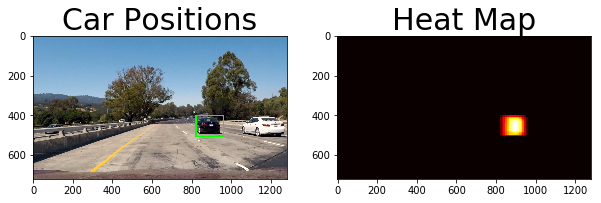

test_images\test2.jpg
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0


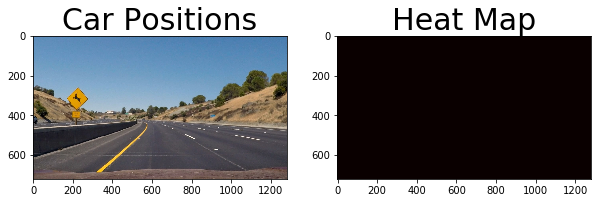

test_images\test3.jpg
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 6.70990227505


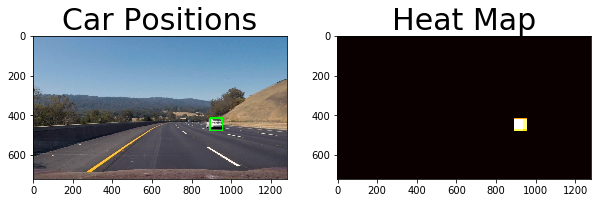

test_images\test4.jpg
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 47.9738568571


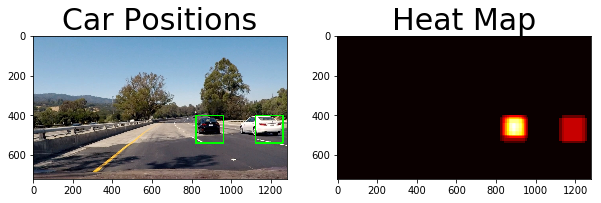

test_images\test5.jpg
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 95.9552327786


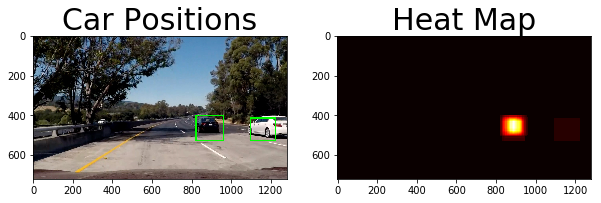

test_images\test6.jpg
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 93.7490723789


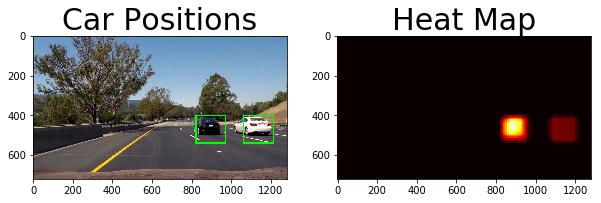

complete test images


In [12]:
test_files = glob.glob('test_images/*.jpg')

for test_file in test_files:
    print(test_file)
    test_img = cv2.imread(test_file)
    draw_img, heatmap = img_vehicle_detect(test_img, file_name=test_file.replace(".jpg", "_proc.png"))
print("complete test images")    

In [80]:
def proc_heatMap(tracking_heatmap, new_heatmap):

    # exponential average the detected heat map
    alpha = 0.8
    tracking_heatmap = alpha * tracking_heatmap + (1 - alpha) * new_heatmap
    
    return tracking_heatmap
   

In [ ]:
# Create a VideoCapture object and read from input file
input_file =  "project_video.mp4"
#input_file =  "test_video.mp4"

output_file = input_file.replace(".", "_proc.")  

cap  = cv2.VideoCapture(input_file)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fps  = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))                      
                       
out = cv2.VideoWriter(output_file,fourcc, fps, size)

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening input video file")

# Check if camera opened successfully
if (out.isOpened()== False): 
    print("Error opening output video file")

tracking_heatmap = np.zeros_like(test_img[:,:,0]).astype(np.float)    
# Read until video is completed
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        proc_img, new_heatmap = img_vehicle_detect(frame)
        
        tracking_heatmap = proc_heatMap(tracking_heatmap, new_heatmap)
        
        # apply the threshold to move the false detection    
        heatmap_thres = apply_threshold(tracking_heatmap, 0.3)
        
        # Visualize the heatmap when displaying    
        heatmap_plot = np.clip(heatmap_thres, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap_plot)
        draw_img = draw_labeled_bboxes(np.copy(frame), labels)
    
        # Display the resulting frame
        cv2.imshow('Frame',draw_img)
        out.write(draw_img)                
 
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
      # Break the loop
    else: 
        break
 
# When everything done, release the video capture object
cap.release()
out.release()
# Closes all the frames
cv2.destroyAllWindows()

C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:24: VisibleDeprecationWarning: using a non-integer number instead of 

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 64

win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 64

win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 64

win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 64

win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 64

win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 64

win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)


C:\self_cars\miniconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 

win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 27.2494594118
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 22.775710548
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size:

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 27.3411504339
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area siz

win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 21.0103563397
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area

win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 16.3178448494
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 17.7694100848
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 28.4311321423
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area siz

win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 14.6052068878
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area

win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 42.9794026822
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 40.2786004174
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 40.2264702677
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area siz

win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 36.6314275173
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area

win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 39.5159659771
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 34.9926169629
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 44.3684047638
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area siz

win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 54.3411597503
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area

win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 23.0034854793
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 22.9304943495
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 17.2480097235
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area siz

win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 11.5900419644
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area

win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 28.8249986846
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 31.3570048025
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 27.6845509277
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area siz

win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 26.9339999657
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area

win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 20.7557821098
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 16.7411090062
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 17.2898090622
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area siz

win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 20.0581665011
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area

win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 11.260325495
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 10.622655739
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 21.7350948828
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area siz

win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 6.87701651487
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area

win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 10.0818721265
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 11.3262739357
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 13.6979973615
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area siz

win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 5.29008474864
win_size: 64


win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 5.59502437562
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 7.21011620659
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 64

win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 64

win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 4.9972101389
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
i

win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 64

win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 9.0057219509
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 8.36900106433
win_

win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.

win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256, 640, 3)
img_resized (73, 182, 3)
win_size: 256.0
img_scale 4.0
proc_area size (256, 640, 3)
img_resized (64, 160, 3)
maximum heat map point 0.0
win_size: 64
img_scale 1
proc_area size (128, 320, 3)
img_resized (128, 320, 3)
win_size: 96.0
img_scale 1.5
proc_area size (192, 480, 3)
img_resized (128, 320, 3)
win_size: 128.0
img_scale 2.0
proc_area size (256, 640, 3)
img_resized (128, 320, 3)
win_size: 160.0
img_scale 2.5
proc_area size (256, 640, 3)
img_resized (102, 256, 3)
win_size: 192.0
img_scale 3.0
proc_area size (256, 640, 3)
img_resized (85, 213, 3)
win_size: 224.0
img_scale 3.5
proc_area size (256